# **Personal Information**
- Class: Programming for Data Science - 23KHDL
- Full name: Trầm Hữu Nhân
- ID: 23127442

## Librabries

In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('..'))

from src.data_processing import *
from src.visualization import *

## Setup

In [2]:
%reload_ext autoreload
%autoreload 2

data = load_dataset('../data/raw/aug_train.csv')

Load successfully!


## Processing Missing Values
From the statistics in the `data_exploration` file from before, the data in my dataset is missing. I will handle the missing data as follows:
- For `numerical` data, for missing values ​​I will fill in the **median** value corresponding to each column.
- For `categorical` data, for missing values ​​I will fill in the **Unknown** value corresponding to each column.

In [3]:
# MISSING VALUE
processed_data = data.copy()

processed_data = impute_numerical(processed_data, 'city_development_index', strategy='median')
processed_data = impute_numerical(processed_data, 'training_hours', strategy='median')

categorical_cols = ['gender', 'major_discipline', 'company_size', 'company_type', 
                    'enrolled_university', 'education_level', 'experience', 'last_new_job']

for col in categorical_cols:
    processed_data = impute_categorical(processed_data, col, fill_value='Unknown')


## Encoding

For `categorical values`, to be able to put text data into the mathematical model, it is necessary to encode them into digital form. I will divide them into 2 groups:
- `Ordinary`: relavent_experience, education_level, experience, company_size, last_new_job
- `One-hot`: gender, enrolled_university, major_discipline, company_type

In [4]:
# Gender
feat_gender, gender_names = encode_one_hot(processed_data, 'gender')

# Relevent Experience
rel_exp_map = {'No relevent experience': 0, 'Has relevent experience': 1}
feat_rel_exp = encode_ordinal(processed_data, 'relevent_experience', rel_exp_map)

# Enrolled University
feat_uni, uni_names = encode_one_hot(processed_data, 'enrolled_university')

# Education Level
edu_map = {'Unknown': 0, 'Primary School': 1, 'High School': 2, 'Graduate': 3, 'Masters': 4, 'Phd': 5}
feat_edu = encode_ordinal(processed_data, 'education_level', edu_map)

# Major discipline
feat_major, major_names = encode_one_hot(processed_data, 'major_discipline')

# Experience
exp_map = {'Unknown': 0, '<1': 1, '>20': 22}
for i in range(1, 21): exp_map[str(i)] = i + 1
feat_exp = encode_ordinal(processed_data, 'experience', exp_map)

# Company Size 
size_map = {'Unknown': 0, '<10': 1, '10/49': 2, '50-99': 3, '100-500': 4, 
            '500-999': 5, '1000-4999': 6, '5000-9999': 7, '10000+': 8}
feat_size = encode_ordinal(processed_data, 'company_size', size_map)

# Company Type
feat_type, type_names = encode_one_hot(processed_data, 'company_type')

# Last new job
last_job_map = {'Unknown': 0, 'never': 1, '1': 2, '2': 3, '3': 4, '4': 5, '>4': 6}
feat_last_job = encode_ordinal(processed_data, 'last_new_job', last_job_map)

# City
feat_city = encode_frequency(processed_data, 'city')

# Numerical features
feat_cdi = processed_data['city_development_index']

feat_hours = processed_data['training_hours']

## Correlation Heatmap

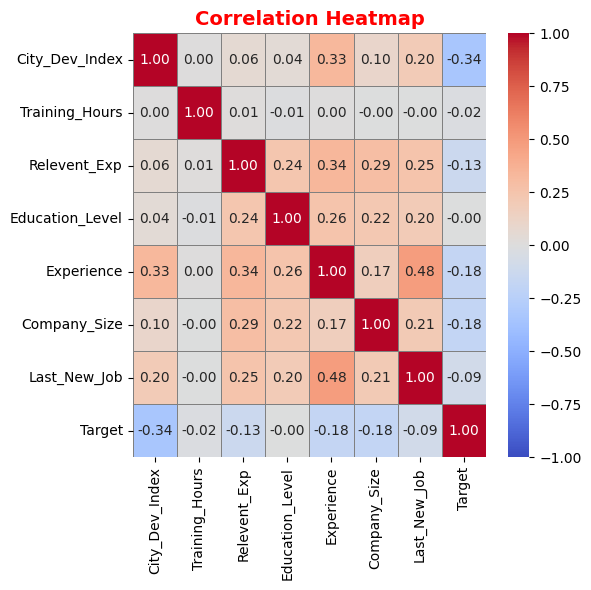

In [5]:
vars_to_plot = [
    processed_data['city_development_index'], # Numerical
    processed_data['training_hours'],         
    feat_rel_exp,   # Ordinal (Binary)
    feat_edu,       
    feat_exp,      
    feat_size,      
    feat_last_job   
]

names_to_plot = [
    'City_Dev_Index',
    'Training_Hours', 
    'Relevent_Exp',
    'Education_Level',
    'Experience',
    'Company_Size',
    'Last_New_Job'
]

X_subset = np.column_stack(vars_to_plot)

if X_subset.shape[1] == len(names_to_plot):
    plot_correlation_heatmap(X_subset, processed_data['target'].astype(int), names_to_plot)
else:
    print("Error: Number of variables does not match number of names.")

**Conclusion**:
- **The Talent Magnet Effect** (Relationship between `experience` - `city_dev_index`): Human resources often start their careers in small/developing cities to gain experience, then migrate to metropolitan areas (high CDI) to develop their peak careers.
- **The Stability Curve** (Relationship between `experience` - `last_new_job`): The more years of experience, the longer the gap between job changes.
- **Corporate Maturity Track** (Relationship between `experience` - `company_size`): Candidates often use Startups as a springboard to learn quickly, then look to large companies to seek stability and benefits.

## Feature Engineering
After the EDA implementation process, I recoded the features and created new features to optimize the performance of the problem.

### Current Features
The features will be divided into groups: `Numerical`, `Ordinary`, `One-hot` accordingly and the following techniques will be applied:
- **Drop First** (for `one-hot` features): All One-Hot variables are truncated in the first column to avoid **Singular Matrix** phenomenon due to perfect multicollinearity.
- **Logtransform** and **Standard Scaler** (for some `ordianry` and `numerical`): Helps the model fairly weight these variables relative to continuous variables

In [6]:
# Numerical
feat_cdi = standard_scaling(processed_data['city_development_index'].reshape(-1, 1))

hours_log = np.log1p(processed_data['training_hours'])
feat_hours = hours_log.reshape(-1, 1)

# Ordinary
exp_map = {'Unknown': 0, '<1': 1, '>20': 22}
for i in range(1, 21): exp_map[str(i)] = i + 1
feat_exp_ord = encode_ordinal(processed_data, 'experience', exp_map)
feat_exp = standard_scaling(feat_exp_ord.reshape(-1, 1))

size_map = {'Unknown': 0, '<10': 1, '10/49': 2, '50-99': 3, '100-500': 4, 
            '500-999': 5, '1000-4999': 6, '5000-9999': 7, '10000+': 8}

feat_size_ord = encode_ordinal(processed_data, 'company_size', size_map)
feat_size = standard_scaling(feat_size_ord.reshape(-1, 1))

last_job_map = {'Unknown': 0, 'never': 1, '1': 2, '2': 3, '3': 4, '4': 5, '>4': 6}
feat_last_job_ord = encode_ordinal(processed_data, 'last_new_job', last_job_map)
feat_last_job = standard_scaling(feat_last_job_ord.reshape(-1, 1))

# One hot
feat_edu_full, edu_names = encode_one_hot(processed_data, 'education_level')
feat_edu = feat_edu_full[:, 1:] 

feat_rel_exp_full, rel_exp_names = encode_one_hot(processed_data, 'relevent_experience')
feat_rel_exp = feat_rel_exp_full[:, 1:]

major_raw = processed_data['major_discipline']
if major_raw.dtype.kind == 'S':
    major_raw = np.array([x.decode('utf-8') for x in major_raw])
feat_major = (major_raw == 'STEM').astype(int).reshape(-1, 1)

feat_gender_full, gender_names = encode_one_hot(processed_data, 'gender')
feat_gender = feat_gender_full[:, 1:]

feat_uni_full, uni_names = encode_one_hot(processed_data, 'enrolled_university')
feat_uni = feat_uni_full[:, 1:]

feat_type_full, type_names = encode_one_hot(processed_data, 'company_type')
feat_type = feat_type_full[:, 1:]

### New Features
- `high_exp_low_cdi`: High experience in underdeveloped areas
- `is_job_hopper`: is it possible to change jobs ?
- `growth`: suitability for current job
- `stability`: loyalty level
- `pressure`: competitive pressure
- `training_intensity`: learning intensity
- `size_missing`: those who did not fill in the company


In [7]:
exp_ord_col = feat_exp_ord.reshape(-1, 1) 
cdi_col = processed_data['city_development_index'].reshape(-1, 1)
raw_high_exp_low_cdi = exp_ord_col * (1 - cdi_col)

feat_high_exp_low_cdi = standard_scaling(raw_high_exp_low_cdi)

is_job_hopper = ((feat_last_job_ord == 2) & (feat_exp_ord > 6)).astype(int)

feat_growth = standard_scaling(feat_exp**3 * feat_size**2)

feat_stability = standard_scaling(feat_exp**2 * feat_last_job**2)

feat_pressure = standard_scaling(feat_cdi**2 * feat_hours**2)

feat_training_intensity = standard_scaling(feat_hours**2 / (feat_exp**2 + 1))

feat_size_missing = (processed_data['company_size'] == 'Unknown').astype(int).reshape(-1, 1)

### X_features 



In [8]:
X_features = np.column_stack([
    feat_cdi, feat_hours,     
    feat_exp, feat_size, feat_last_job,
    feat_gender, feat_uni, feat_major, feat_type, feat_rel_exp, feat_edu,
    feat_high_exp_low_cdi, is_job_hopper, feat_growth, feat_stability, feat_pressure, feat_training_intensity, feat_size_missing
])

y = processed_data['target'].astype(int)

## Statistical Hypothesis Testing
To determine whether **Training Hours (Training Hours)** actually affects a candidate's decision to leave a job, we performed a **Two-Sample T-test** (T-Test for Two Independent Samples).

### Hypotheses Formulation
Let $\mu_{stay}$ and $\mu_{leave}$ be the average number of training hours of the "Stay" group (`Target`=0) and the "Leave" group (`Targe`t=1), respectively.

I have the following pair of hypotheses:

* **Null hypothesis ($H_0$):** There is no difference in training time between the two groups.

$$H_0: \mu_{stay} = \mu_{leave}$$

* **Alternative hypothesis ($H_1$):** There is a statistically significant difference in training time between the two groups.

$$H_1: \mu_{stay} \neq \mu_{leave}$$

### Methodology & Assumptions
- **Significance level ($\alpha$):** 0.05 (95% confidence level).
- **Critical Value:** $z_{\alpha/2} \approx 1.96$ (with large sample $N > 30$).
- **Data processing:**
    - The original data of `training_hours` has a right-skewed distribution.
    - To satisfy the **Normality Assumption** of the T-test, I performed **Log-transformation** (`np.log1p`) and **Standard Scaling** before testing.

In [9]:
group_stay = X_features[y == 0, 1]
group_leave = X_features[y == 1, 1]

t_stat, m1, m2 = t_test_manual(group_stay, group_leave)

print(f"Mean Hours (Stay): {m1:.2f}")
print(f"Mean Hours (Leave): {m2:.2f}")
print(f"T-statistic: {t_stat:.4f}")

if abs(t_stat) > 1.96:
    print("=> Reject H0. There is a difference in the number of training hours between the two groups..")
else:
    print("=> Accept H0. There is a similarity in the number of training hours between the two groups.")

Mean Hours (Stay): 3.81
Mean Hours (Leave): 3.78
T-statistic: 1.8161
=> Accept H0. There is a similarity in the number of training hours between the two groups.


## Processed Data

Instead of saving to `.csv` file as usual, I will save to `.npy` file for the following reasons:
- I/O performance 
- Data Precision
- Multi-dimensional Arrays
- Smaller storage capacity

In [10]:
# Save data
os.makedirs('../data/processed', exist_ok=True)

np.save('../data/processed/X_train.npy', X_features)
np.save('../data/processed/y_train.npy', y)